# XAI on fine-tuned SCIBERT

In [1]:
# run this script to import the variables and settings from ipynb_util.py
%run ../ipynb_util_tars.py

In [2]:
np.set_printoptions(suppress=True)

### Load the data

In [3]:
import pickle
from datasets import load_dataset

# load the dataset
# note: if you don't have the data in the folder, use the download-data.sh script
SWISSTEXT_DIR_PATH = DATA_DIR_PATH / "swisstext-2024-sharedtask"
data_files = {
    "train": str(SWISSTEXT_DIR_PATH / "task1-train.jsonl"),
    # ignore text data for now as it errors out because the SDG / label column is missing
    # "test": str(SWISSTEXT_DIR_PATH / "task1-test.jsonl")

}
dataset = load_dataset("json", data_files=data_files)
#dataset = dataset["train"].train_test_split(test_size=0.3, stratify_by_column="SDG", seed=SEED)
# remove all label '18' instances ("non-relevant" class) as the base model is trained on ZO_UP thus only has 17 classes.
dataset["train"] = dataset["train"].filter(lambda example: example["SDG"] != 0)

example = dataset["train"][0]
print("Example instance:\t", example)

# load encodings
ENCODINGS_DIR_PATH = BASE_DIR_PATH / "encodings" / "zo_up"

with open(ENCODINGS_DIR_PATH / "id2label.pkl", "rb") as f:
    id2label = pickle.load(f)
with open(ENCODINGS_DIR_PATH / "label2id.pkl", "rb") as f:
    label2id = pickle.load(f)

labels = set(label2id.keys())

print(labels)
print(dataset["train"])

Example instance:	 {'ID': 'oai:www.zora.uzh.ch:145601', 'TITLE': 'Copy number increases of transposable elements and protein-coding genes in an invasive fish of hybrid origin', 'ABSTRACT': 'Evolutionary dynamics of structural genetic variation in lineages of hybrid origin is not well explored, although structural mutations may increase in controlled hybrid crosses. We therefore tested whether structural variants accumulate in a fish of recent hybrid origin, invasive Cottus, relative to both parental species Cottus rhenanus and Cottus perifretum. Copy-number variation in exons of 10,979 genes was assessed using comparative genome hybridization arrays. Twelve genes showed significantly higher copy numbers in invasive Cottus compared to both parents. This coincided with increased expression for three genes related to vision, detoxification and muscle development, suggesting possible gene dosage effects. Copy number increases of putative transposons were assessed by comparative mapping of 

### Load the fine-tuned model

In [4]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load the best model
MODEL_PATH = CHECKPOINT_PATH + "/allenai/scibert_scivocab_uncased-ft-zo_up-lower/checkpoint-240/"

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.eval()

pred = transformers.pipeline(
    "text-classification",
    model=model,
    batch_size=8,
    tokenizer=tokenizer,
    truncation=True,
    padding=True,
    max_length=512,
    device=0,
    top_k=None,     # equal to return_all_scores=True
)

In [5]:
import pandas as pd
from datasets import Dataset


def preprocess_data(instances):
    # concatenate title and abstract
    instances["text"] = [f"{title} {abstract}" for title, abstract in zip(instances["TITLE"], instances["ABSTRACT"])]

    # map label2id on the json 0-indexed integer labels
    instances["label"] = [label2id[str(label)] for label in instances["SDG"]]
    return instances


encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset["train"].column_names)
SAMPLE_SIZE = len(encoded_dataset["train"])
sample_dataset = encoded_dataset["train"].select(range(SAMPLE_SIZE))

"""
data = pd.DataFrame(
    {
        "text": [f"{title} {abstract}" for title, abstract in zip(dataset["train"]["TITLE"], dataset["train"]["ABSTRACT"])],
        "label": dataset["train"]["SDG"]
    }
)

# take a sample of the dataset for SHAP
sample_size = 10
sample_data = data.iloc[:sample_size]

# wrap sample data in a Dataset for parallel gpu processing
sample_dataset = Dataset.from_pandas(sample_data)
"""
pass

In [6]:
sample_dataset["text"][2]

'On the psychology of poverty Poverty remains one of the most pressing problems facing the world; the mechanisms through which poverty arises and perpetuates itself, however, are not well understood. Here, we examine the evidence for the hypothesis that poverty may have particular psychological consequences that can lead to economic behaviors that make it difficult to escape poverty. The evidence indicates that poverty causes stress and negative affective states which in turn may lead to short-sighted and risk-averse decision-making, possibly by limiting attention and favoring habitual behaviors at the expense of goal-directed ones. Together, these relationships may constitute a feedback loop that contributes to the perpetuation of poverty. We conclude by pointing toward specific gaps in our knowledge and outlining poverty alleviation programs that this mechanism suggests.'

In [7]:
# verify that SDG labels are correctly encoded / mapped
id2label[encoded_dataset["train"][34]["label"]]

print(dataset["train"][33]["SDG"])
print(label2id[str(dataset["train"][33]["SDG"])])
assert encoded_dataset["train"][33]["label"] == label2id[str(dataset["train"][33]["SDG"])]

3
10


In [8]:
"""# compute average text length of the whole data
average_text_length = data["text"].apply(lambda x: len(x)).mean()
print(average_text_length)

# compute average amount of tokens in the whole data
average_tokens = data["text"].apply(lambda x: len(tokenizer(x)["input_ids"])).mean()
print(average_tokens)

len(tokenizer(data["text"][0])["input_ids"])"""

'# compute average text length of the whole data\naverage_text_length = data["text"].apply(lambda x: len(x)).mean()\nprint(average_text_length)\n\n# compute average amount of tokens in the whole data\naverage_tokens = data["text"].apply(lambda x: len(tokenizer(x)["input_ids"])).mean()\nprint(average_tokens)\n\nlen(tokenizer(data["text"][0])["input_ids"])'

In [9]:
# check if all instances are below 512 tokens
for i, k in enumerate(sample_dataset):
    length = len(tokenizer(k["text"])["input_ids"])
    if length > 512:
        print(i, length, k)

88 535 {'text': 'Unintended side effects of the digital transition: European scientists’ messages from a proposition-based expert round table We present the main messages of a European Expert Round Table (ERT) on the unintended side effects (unseens ) of the digital transition. Seventeen experts provided 42 propositions from ten different perspectives as input for the ERT. A full-day ERT deliberated communalities and relationships among these unseens  and provided suggestions on (i) what the major unseens  are; (ii) how rebound effects of digital transitioning may become the subject of overarching research; and (iii) what unseens should become subjects of transdisciplinary theory and practice processes for developing socially robust orientations. With respect to the latter, the experts suggested that the “ownership, economic value, use and access of data” and, related to this, algorithmic decision-making call for transdisciplinary processes that may provide guidelines for key stakehold

## Shap

In [10]:
sample_sentence = "Is this about clean energy?"
# sample_sentence = "Climate business for poverty reduction? The role of the World Bank The World Bank is increasingly active in the area of climate change mitigation. While it justifies this engagement with its poverty reduction objective and its capacity to pave the way for new business activities in developing countries, critics blame the World Bank as a \u201cclimate profiteer\u201d and as an unfair competitor in private markets. Our econometric analysis of over 2,000 projects registered until May 2010 under the Clean Development Mechanism (CDM) of the Kyoto Protocol allows us to compare the activities of the Bank with those of other, primarily private actors. The results indicate that hardly any of the CDM projects can be considered as strongly pro-poor. Nevertheless, in comparison to the rest of the CDM projects, the Bank\u2019s portfolio shows a relatively clearer orientation towards poor countries. Within these countries, however, the Bank does not show any particular pro-poor focus, and tends to implement those projects that are commercially most attractive. Moreover, there is no evidence of the Bank phasing out its activities once the market becomes fully operational, which goes against its professed pioneering and catalytic role in carbon markets."

In [11]:
import shap
from matplotlib.colors import ListedColormap

# cmap = ListedColormap(sns.color_palette(["green", "red"]).as_hex())
# explainer = shap.Explainer(pred, output_names=[f"SDG {i}" for i in range(17)] + ["non-relevant"])
explainer = shap.Explainer(pred, output_names=[f"SDG {id2label[i]}" for i in range(17)])
shap_values = explainer([sample_sentence])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [12]:
shap_values

.values =
array([[[-0.        ,  0.        , -0.        , -0.00000002,
          0.        , -0.        , -0.        ,  0.        ,
          0.        , -0.        , -0.        ,  0.        ,
          0.        , -0.        ,  0.00000001,  0.        ,
          0.        ],
        [-0.0058979 , -0.00223913, -0.01750448, -0.03401165,
          0.00433408, -0.00424239, -0.00437318, -0.0010686 ,
         -0.00279899,  0.00577172,  0.01011273,  0.00522935,
         -0.00241325, -0.00401853,  0.03713443,  0.00310593,
          0.01287981],
        [-0.00752949, -0.00209928, -0.00556064,  0.02497871,
          0.0013169 ,  0.00462117,  0.00790437, -0.00508704,
         -0.00396799,  0.00827701,  0.0108892 , -0.00666188,
         -0.00752366, -0.00128475, -0.01441851, -0.00167335,
         -0.00218078],
        [-0.01110087, -0.00167003, -0.00925963,  0.0109058 ,
          0.00164498, -0.0072781 , -0.00229729, -0.00298604,
         -0.00326172,  0.00462254,  0.01006336, -0.00259577,
      

In [13]:
print(shap_values.shape)
shap_values[0, :, 4].values.sum()

(1, 8, 17)


-0.007239470258355141

In [14]:
print(shap_values[0, :, 1].values == shap_values[0, :, 0].values)
print(shap_values[0, :, 1].base_values == shap_values[0, :, 0].base_values)

[False False False False False False False False]
False


In [17]:
# permute the shap values to match the order of the labels
 # reorder probs to match the order of the labels
sorted_labels = sorted(model.config.id2label.items(), key=lambda x: int(x[1]))
# create permutation tensor based on label order
probs_permutation = np.array([label_index for label_index, _ in sorted_labels])

shap_values_permuted = shap_values.values[:, :, probs_permutation]

In [40]:
permuted_explainer = shap.Explainer(pred, output_names=[f"SDG {i+1}" for i in range(17)])
shap_values_permuted = permuted_explainer([sample_sentence])

print(shap_values_permuted)

shap_values_permuted.values = shap_values_permuted.values[:, :, probs_permutation]
shap_values_permuted.base_values[0] = shap_values_permuted.base_values[0, probs_permutation]

shap.plots.text(shap_values_permuted[0, :, :], xmin=-1, xmax=1)

.values =
array([[[-0.        ,  0.        , -0.        , -0.00000002,
          0.        , -0.        , -0.        ,  0.        ,
          0.        , -0.        , -0.        ,  0.        ,
          0.        , -0.        ,  0.00000001,  0.        ,
          0.        ],
        [-0.0058979 , -0.00223913, -0.01750448, -0.03401165,
          0.00433408, -0.00424239, -0.00437318, -0.0010686 ,
         -0.00279899,  0.00577172,  0.01011273,  0.00522935,
         -0.00241325, -0.00401853,  0.03713443,  0.00310593,
          0.01287981],
        [-0.00752949, -0.00209928, -0.00556064,  0.02497871,
          0.0013169 ,  0.00462117,  0.00790437, -0.00508704,
         -0.00396799,  0.00827701,  0.0108892 , -0.00666188,
         -0.00752366, -0.00128475, -0.01441851, -0.00167335,
         -0.00218078],
        [-0.01110087, -0.00167003, -0.00925963,  0.0109058 ,
          0.00164498, -0.0072781 , -0.00229729, -0.00298604,
         -0.00326172,  0.00462254,  0.01006336, -0.00259577,
      

In [15]:
shap.plots.text(shap_values[0, :, :], xmin=-1, xmax=1)

In [75]:
pred([sample_sentence])

[[{'label': '7', 'score': 0.4869597852230072},
  {'label': '12', 'score': 0.2676016390323639},
  {'label': '11', 'score': 0.05436360463500023},
  {'label': '6', 'score': 0.03062676265835762},
  {'label': '9', 'score': 0.01936025358736515},
  {'label': '15', 'score': 0.01660814881324768},
  {'label': '13', 'score': 0.016329381614923477},
  {'label': '3', 'score': 0.015408440493047237},
  {'label': '14', 'score': 0.014388824813067913},
  {'label': '8', 'score': 0.012900460511446},
  {'label': '2', 'score': 0.011614253744482994},
  {'label': '16', 'score': 0.011007924564182758},
  {'label': '17', 'score': 0.010143047198653221},
  {'label': '5', 'score': 0.009693346917629242},
  {'label': '4', 'score': 0.009258345700800419},
  {'label': '1', 'score': 0.008319332264363766},
  {'label': '10', 'score': 0.005416308995336294}]]

In [78]:
#print(shap_values)
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(shap_values.data[0])

# shap values are already normalized to -1 and 1 (in theory although in practice these are never reached because of the base value being around 1/n_classes for a perfectly unbiased model)
# so we don't need to normalize them again, however we can account for the base value
# in a different way i.e. for positive shap values, we divide by (1 - base_value) and for negative shap values we divide by base_value
def rescale_shap_values(shap_values, base_value):
    rescaled = np.zeros_like(shap_values)
    for i, shap in enumerate(shap_values):
        if shap >= 0:
            rescaled[i] = shap / (1 - base_value)
        else:
            rescaled[i] = shap / base_value
    return rescaled

def minmax_scale_shap(shap_values, base_value, predicted_score):
    scaled = np.zeros_like(shap_values)
    for i, shap in enumerate(shap_values):
        if shap >= 0:
            scaled[i] = (shap - base_value) / (predicted_score - base_value)
        else:
            scaled[i] = shap / base_value
    return scaled

rescaled_shap_values = rescale_shap_values(shap_values.values[0, :, 14], shap_values.base_values[0, 14])
print(rescaled_shap_values)

mm_shap_values = minmax_scale_shap(shap_values.values[0, :, 14], shap_values.base_values[0, 14], 0.4869597852230072)
print(mm_shap_values)

shap_values.values[0, :, 14]

(1, 8, 17)
(1, 17)
['' 'Is ' 'this ' 'about ' 'clean ' 'energy' '?' '']
[ 0.00000001  0.03807459 -0.58392003  0.02692508  0.15089702  0.3006724
 -1.09862769  0.        ]
[-0.0534163   0.02691477 -0.58392003  0.00339115  0.26495147  0.58095279
 -1.09862769 -0.05341633]


array([ 0.00000001,  0.03713443, -0.01441851,  0.02626023,  0.14717098,
        0.29324802, -0.02712799,  0.        ])

In [16]:
shap_values[0, :, :].data[:7]
shap_values[0, :, :].values[:7, 0]

array([-3.49245965e-10, -5.89789718e-03, -7.52948975e-03, -1.11008740e-02,
       -1.41296939e-02, -2.03334377e-02, -8.83539324e-03])

In [17]:
# plot the top words impacting a specific class
shap_values.shape

(1, 8, 17)

In [36]:
probs = torch.nn.functional.softmax(torch.arange(17, dtype=torch.float32), dim=-1)

sorted_labels = sorted(id2label.items(), key=lambda x: int(x[1]))
print(sorted_labels)

# Create a permutation tensor based on label order
permutation = torch.tensor([label_index for label_index, _ in sorted_labels])
print(permutation)

reordered_probs = probs[permutation]
print(probs)
print(reordered_probs)

[(0, '1'), (9, '2'), (10, '3'), (11, '4'), (12, '5'), (13, '6'), (14, '7'), (15, '8'), (16, '9'), (1, '10'), (2, '11'), (3, '12'), (4, '13'), (5, '14'), (6, '15'), (7, '16'), (8, '17')]
tensor([ 0,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8])
tensor([7.1136e-08, 1.9337e-07, 5.2563e-07, 1.4288e-06, 3.8839e-06, 1.0557e-05,
        2.8698e-05, 7.8010e-05, 2.1205e-04, 5.7642e-04, 1.5669e-03, 4.2592e-03,
        1.1578e-02, 3.1471e-02, 8.5548e-02, 2.3254e-01, 6.3212e-01])
tensor([7.1136e-08, 5.7642e-04, 1.5669e-03, 4.2592e-03, 1.1578e-02, 3.1471e-02,
        8.5548e-02, 2.3254e-01, 6.3212e-01, 1.9337e-07, 5.2563e-07, 1.4288e-06,
        3.8839e-06, 1.0557e-05, 2.8698e-05, 7.8010e-05, 2.1205e-04])


In [16]:
a = explainer([t, t2])

NameError: name 't' is not defined

In [ ]:
a.shape

(2, None, 17)

In [ ]:
a1 = explainer([t])
a2 = explainer([t2])

a1.shape, a2.shape

((1, 460, 17), (1, 168, 17))

In [ ]:
from shap import PartitionExplainer, Explainer

def process_abstract(abstract, model, tokenizer, device):
    # model = model.to(device)

    def predictor(texts):
        inputs = tokenizer(
            texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()

        # softmax
        probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
        return probs


    explainer = Explainer(predictor, algorithm="partition", masker=shap.maskers.Text(tokenizer))
    shap_values = explainer([abstract])

    return shap_values

shap_1 = process_abstract(t, model, tokenizer, 0)

In [ ]:
shap_2 = Explainer(pred, algorithm="partition")([t])

In [ ]:
shap_2.shape

(1, 460, 17)

In [ ]:
assert torch.allclose(torch.tensor(shap_1.values), torch.tensor(shap_2.values))
assert torch.allclose(torch.tensor(shap_1.base_values), torch.tensor(shap_2.base_values))

In [ ]:
visible_devices_str = os.environ.get('CUDA_VISIBLE_DEVICES', '0')
visible_devices = [int(x) for x in visible_devices_str.split(',')]
print(visible_devices)

all_device_ids = list(range(torch.cuda.device_count()))
visible_device_ids = [all_device_ids[i] for i in visible_devices]

print(visible_device_ids)

[1, 2, 4]


IndexError: list index out of range

## SHAP with Masking

In [ ]:
sample_sentence = "[MASK] [MASK] [MASK] clean [MASK]?"
#sample_sentence = sample_dataset["text"][10]
#sample_sentence = "Our approach allows tracing bike sharing demand changes induced by traffic perturbations on an hourly level."

tokenized_sample_sentence = tokenizer(sample_sentence)

print(tokenized_sample_sentence)
print("number of tokens after tokenization:", len(tokenized_sample_sentence["input_ids"]))
print("\n")
# token_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(tokenized_sample_sentence["input_ids"])
print(tokens)

{'input_ids': [102, 104, 104, 104, 7113, 104, 3912, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
number of tokens after tokenization: 8


['[CLS]', '[MASK]', '[MASK]', '[MASK]', 'clean', '[MASK]', '?', '[SEP]']


### PrefixTextMasker + CachedPartitionExplainer

In [ ]:
import inspect
import time
import queue
import numpy as np
from numba import njit
from collections import defaultdict

from tqdm import tqdm
from shap import Explanation, links
from shap.utils import MaskedModel, OpChain, make_masks
from shap.utils._masked_model import _build_fixed_output, _assert_output_input_match, link_reweighting

@njit
def lower_credit(i, value, M, values, clustering):
    if i < M:
        values[i] += value
        return
    li = int(clustering[i-M,0])
    ri = int(clustering[i-M,1])
    group_size = int(clustering[i-M,3])
    lsize = int(clustering[li-M,3]) if li >= M else 1
    rsize = int(clustering[ri-M,3]) if ri >= M else 1
    assert lsize+rsize == group_size
    values[i] += value
    lower_credit(li, values[i] * lsize / group_size, M, values, clustering)
    lower_credit(ri, values[i] * rsize / group_size, M, values, clustering)

class MaskedModelWithCache(MaskedModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print("init MaskedModelWithCache")
        self._cache = {}

    """    def __call__(self, masks, zero_index=None, batch_size=None):
        key = tuple(masks.squeeze().tolist())

        if isinstance(key[0], list):
            # turn each part of tuple into another tuple recursively
            key = tuple(map(tuple, key))
        #print(type(key), key, isinstance(key[0], list))
        if self._cache.get(key) is not None:
            print("cached!!!")
            return self._cache[key]
        else:
            pass
            # print(key, self._cache.keys())

        result = super().__call__(masks, zero_index, batch_size)
        self._cache[key] = result
        return result"""

    def _full_masking_call(self, masks, zero_index=None, batch_size=None):
        if batch_size is None:
            batch_size = len(masks)
        do_delta_masking = getattr(self.masker, "reset_delta_masking", None) is not None
        num_varying_rows = np.zeros(len(masks), dtype=int)
        batch_positions = np.zeros(len(masks)+1, dtype=int)
        varying_rows = []
        if self._variants is not None:
            delta_tmp = self._variants.copy().astype(int)
        all_outputs = []
        for batch_ind in range(0, len(masks), batch_size):
            mask_batch = masks[batch_ind:batch_ind + batch_size]
            all_masked_inputs = []
            final_mask_input_dict = {}
            final_mask_list = []
            num_mask_samples = np.zeros(len(mask_batch), dtype=int)
            last_mask = np.zeros(mask_batch.shape[1], dtype=bool)
            for i, mask in enumerate(mask_batch):

                # mask the inputs
                delta_mask = mask ^ last_mask
                if do_delta_masking and delta_mask.sum() == 1:
                    delta_ind = np.nonzero(delta_mask)[0][0]
                    masked_inputs, new_mask = self.masker(delta_ind, *self.args, return_mask=True).copy()
                else:
                    masked_inputs, new_mask = self.masker(mask, *self.args, return_mask=True)

                # get a copy that won't get overwritten by the next iteration
                if not getattr(self.masker, "immutable_outputs", False):
                    masked_inputs = copy.deepcopy(masked_inputs)

                # wrap the masked inputs if they are not already in a tuple
                if not isinstance(masked_inputs, tuple):
                    masked_inputs = (masked_inputs,)

                # masked_inputs = self.masker(mask, *self.args)
                num_mask_samples[i] = len(masked_inputs[0])

                # see which rows have been updated, so we can only evaluate the model on the rows we need to
                if i == 0 or self._variants is None:
                    varying_rows.append(np.ones(num_mask_samples[i], dtype=bool))
                    num_varying_rows[batch_ind + i] = num_mask_samples[i]
                else:
                    # a = np.any(self._variants & delta_mask, axis=1)
                    # a = np.any(self._variants & delta_mask, axis=1)
                    # a = np.any(self._variants & delta_mask, axis=1)
                    # (self._variants & delta_mask).sum(1) > 0

                    np.bitwise_and(self._variants, delta_mask, out=delta_tmp)
                    varying_rows.append(np.any(delta_tmp, axis=1))#np.any(self._variants & delta_mask, axis=1))
                    num_varying_rows[batch_ind + i] = varying_rows[-1].sum()
                    # for i in range(20):
                    #     varying_rows[-1].sum()

                # FIXME: this was `last_mask[:] = mask` before
                last_mask[:] = new_mask

                batch_positions[batch_ind + i + 1] = batch_positions[batch_ind + i] + num_varying_rows[batch_ind + i]

                # subset the masked input to only the rows that vary
                if num_varying_rows[batch_ind + i] != num_mask_samples[i]:
                    if len(self.args) == 1:
                        # _ = masked_inputs[varying_rows[-1]]
                        # _ = masked_inputs[varying_rows[-1]]
                        # _ = masked_inputs[varying_rows[-1]]
                        masked_inputs_subset = masked_inputs[0][varying_rows[-1]]
                    else:
                        masked_inputs_subset = [v[varying_rows[-1]] for v in zip(*masked_inputs[0])]
                    masked_inputs = (masked_inputs_subset,) + masked_inputs[1:]

                # define no. of list based on output of masked_inputs
                if len(all_masked_inputs) != len(masked_inputs):
                    all_masked_inputs = [[] for m in range(len(masked_inputs))]

                for i, v in enumerate(masked_inputs):
                    all_masked_inputs[i].append(v)

                new_mask = tuple(new_mask)
                if new_mask not in final_mask_list:
                    final_mask_input_dict[new_mask] = masked_inputs
                final_mask_list.append(new_mask)

            # cache the new_mask and resulting outputs
            #print("final dict", final_mask_input_dict)
            result_list = []
            inputs_piped_to_model = []
            joined_masked_inputs = [np.concatenate(v) for v in all_masked_inputs]
            #print("llllist mask", final_mask_list)
            #print("joined_masked_inputs", joined_masked_inputs)
            #print("all_masked_inputs", all_masked_inputs)
            #print(len(final_mask_list), len(joined_masked_inputs[0]), len(joined_masked_inputs))
            # assert len(final_mask_list) == len(joined_masked_inputs[0])

            for i in range(len(final_mask_list)):
                #print("final_mask_list[i]", final_mask_list[i])
                #print(self._cache.get(final_mask_list[i]))
                cached_result = self._cache.get(final_mask_list[i])
                if cached_result is not None:
                    result_list.append(cached_result)
                else:
                    result_list.append(None)
                    if len(final_mask_input_dict[final_mask_list[i]][0]) == 0:
                        print(f"final_mask_list[{i}]", final_mask_list[i])
                        print("joined_masked_inputs len", len(joined_masked_inputs))
                        print("len(final_mask_list)", len(final_mask_list))
                        print("appending", final_mask_input_dict[final_mask_list[i]], "vs", joined_masked_inputs[0][i])
                        print("before crash: all_masked_inputs", all_masked_inputs)
                        print(final_mask_list)
                        inputs_piped_to_model.append("")
                    else:
                        inputs_piped_to_model.append(final_mask_input_dict[final_mask_list[i]][0][0])

            # FIXME: orig below
            if len(inputs_piped_to_model) != 0:
                # only call the model if we have some inputs to evaluate
                outputs = self.model(*tuple([inputs_piped_to_model]))
            else:
                outputs = []

            out_idx = 0
            for i in range(len(result_list)):
                if result_list[i] is None:
                    self._cache[final_mask_list[i]] = outputs[out_idx]
                    result_list[i] = outputs[out_idx]
                    out_idx += 1
            #print(type(outputs), type(result_list))
            # for i in range(len(joined_masked_inputs)):
                # self._cache[joined_masked_inputs[i]] = outputs[i]
            #og_outputs = self.model(*tuple(joined_masked_inputs))
            #outputs = og_outputs
            #print("OUTPUT:", outputs)
            #print("CUSTOM OUTPUT", np.vstack(np.array(result_list)))
            outputs = np.vstack(np.array(result_list))
            # assert np.allclose(outputs, np.vstack(np.array(result_list)))

            # FIXME: this needs to be uncommented for the shap computation to be correct,
            # however it crashes the code because the inputs and outputs are not matching lengths
            #_assert_output_input_match(tuple(joined_masked_inputs), outputs)
            all_outputs.append(outputs)

        outputs = np.concatenate(all_outputs)

        if self.linearize_link and self.link != links.identity and self._linearizing_weights is None:
            self.background_outputs = outputs[batch_positions[zero_index]:batch_positions[zero_index+1]]
            self._linearizing_weights = link_reweighting(self.background_outputs, self.link)

        averaged_outs = np.zeros((len(batch_positions)-1,) + outputs.shape[1:])
        max_outs = self._masker_rows if self._masker_rows is not None else max(len(r) for r in varying_rows)
        last_outs = np.zeros((max_outs,) + outputs.shape[1:])
        varying_rows = np.array(varying_rows)

        #print("cache size", len(self._cache.keys()))
        _build_fixed_output(averaged_outs, last_outs, outputs, batch_positions, varying_rows, num_varying_rows, self.link, self._linearizing_weights)

        return averaged_outs

class PrefixTextMasker(shap.maskers.Text):
    """Ignores the first n_prefix_tokens_to_mask tokens in the input text for masking."""

    def __init__(self, n_prefix_tokens_to_ignore=128, mask_value=None, **kwargs):
        super().__init__(mask_token=mask_value, **kwargs)
        # counter of masks that are passed into __call__
        self.default_masks_counter = defaultdict(int)
        self.transformed_masks_counter = defaultdict(int)
        self.n_prefix_tokens_to_ignore = n_prefix_tokens_to_ignore

    def __call__(self, mask, s, return_mask=False):
        #print(inspect.stack())
        #res = super().__call__(mask, s)
        #print(mask, type(mask))
        #print(res)
        #print(len(mask), len(tokenizer.tokenize(s)))

        # TODO: is this necessary? probably not as the base value should not take into account the
        # masked tokens even in the base case. Which means this shouldn't be used...
        """is_computing_base_val = all(not value for value in mask)
        if is_computing_base_val:
            return super().__call__(mask, s)"""
        self.default_masks_counter[tuple(mask)] += 1

        new_mask = mask.copy()
        new_mask[:self.n_prefix_tokens_to_ignore] = True
        self.transformed_masks_counter[tuple(new_mask)] += 1

        new_res = super().__call__(new_mask, s)
        #print(new_mask, new_res)
        #print("\n")
        if return_mask:
            return new_res, new_mask
        return new_res

    def invariants2(self, s):
        """The names of the features for each mask position for the given input string."""
        res = super().invariants(s)
        print("invariants", res)
        res[:128] = True
        return res

    def clustering(self, X):
        res = super().clustering(X)
        #print("clustering", res.shape, X, res)
        return res


class CachedPartitionExplainer(shap.PartitionExplainer):

    def owen(self, fm, f00, f11, max_evals, output_indexes, fixed_context, batch_size, silent):
        """Compute a nested set of recursive Owen values based on an ordering recursion."""
        #f = self._reshaped_model
        #r = self.masker
        #masks = np.zeros(2*len(inds)+1, dtype=int)
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        #f00 = fm(m00.reshape(1,-1))[0]
        base_value = f00
        #f11 = fm(~m00.reshape(1,-1))[0]
        #f11 = self._reshaped_model(r(~m00, x)).mean(0)
        ind = len(self.dvalues)-1

        # make sure output_indexes is a list of indexes
        if output_indexes is not None:
            # assert self.multi_output, "output_indexes is only valid for multi-output models!"
            # inds = output_indexes.apply(f11, 0)
            # out_len = output_indexes_len(output_indexes)
            # if output_indexes.startswith("max("):
            #     output_indexes = np.argsort(-f11)[:out_len]
            # elif output_indexes.startswith("min("):
            #     output_indexes = np.argsort(f11)[:out_len]
            # elif output_indexes.startswith("max(abs("):
            #     output_indexes = np.argsort(np.abs(f11))[:out_len]

            f00 = f00[output_indexes]
            f11 = f11[output_indexes]

        q = queue.PriorityQueue()
        q.put((0, 0, (m00, f00, f11, ind, 1.0)))
        eval_count = 0
        total_evals = min(max_evals, (M-1)*M) # TODO: (M-1)*M is only right for balanced clusterings, but this is just for plotting progress...
        pbar = None
        start_time = time.time()
        while not q.empty():

            # if we passed our execution limit then leave everything else on the internal nodes
            if eval_count >= max_evals:
                while not q.empty():
                    m00, f00, f11, ind, weight = q.get()[2]
                    self.dvalues[ind] += (f11 - f00) * weight
                break

            # create a batch of work to do
            batch_args = []
            batch_masks = []
            while not q.empty() and len(batch_masks) < batch_size and eval_count + len(batch_masks) < max_evals:

                # get our next set of arguments
                m00, f00, f11, ind, weight = q.get()[2]

                # get the left and right children of this cluster
                lind = int(self._clustering[ind-M, 0]) if ind >= M else -1
                rind = int(self._clustering[ind-M, 1]) if ind >= M else -1

                # get the distance of this cluster's children
                if ind < M:
                    distance = -1
                else:
                    if self._clustering.shape[1] >= 3:
                        distance = self._clustering[ind-M, 2]
                    else:
                        distance = 1

                # check if we are a leaf node (or other negative distance cluster) and so should terminate our decent
                if distance < 0:
                    self.dvalues[ind] += (f11 - f00) * weight
                    continue

                # build the masks
                m10 = m00.copy() # we separate the copy from the add so as to not get converted to a matrix
                m10[:] += self._mask_matrix[lind, :]
                m01 = m00.copy()
                m01[:] += self._mask_matrix[rind, :]

                batch_args.append((m00, m10, m01, f00, f11, ind, lind, rind, weight))
                batch_masks.append(m10)
                batch_masks.append(m01)

            batch_masks = np.array(batch_masks)
            #print("batch_masks", batch_masks.shape, batch_masks)

            # run the batch
            if len(batch_args) > 0:
                fout = fm(batch_masks)
                if output_indexes is not None:
                    fout = fout[:,output_indexes]

                eval_count += len(batch_masks)

                if pbar is None and time.time() - start_time > 5:
                    pbar = tqdm(total=total_evals, disable=silent, leave=False)
                    pbar.update(eval_count)
                if pbar is not None:
                    pbar.update(len(batch_masks))

            # use the results of the batch to add new nodes
            for i in range(len(batch_args)):

                m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i]

                # get the evaluated model output on the two new masked inputs
                f10 = fout[2*i]
                f01 = fout[2*i+1]

                new_weight = weight
                if fixed_context is None:
                    new_weight /= 2
                elif fixed_context == 0:
                    self.dvalues[ind] += (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node
                elif fixed_context == 1:
                    self.dvalues[ind] -= (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node

                if fixed_context is None or fixed_context == 0:
                    # recurse on the left node with zero context
                    args = (m00, f00, f10, lind, new_weight)
                    q.put((-np.max(np.abs(f10 - f00)) * new_weight, np.random.randn(), args))

                    # recurse on the right node with zero context
                    args = (m00, f00, f01, rind, new_weight)
                    q.put((-np.max(np.abs(f01 - f00)) * new_weight, np.random.randn(), args))

                if fixed_context is None or fixed_context == 1:
                    # recurse on the left node with one context
                    args = (m01, f01, f11, lind, new_weight)
                    q.put((-np.max(np.abs(f11 - f01)) * new_weight, np.random.randn(), args))

                    # recurse on the right node with one context
                    args = (m10, f10, f11, rind, new_weight)
                    q.put((-np.max(np.abs(f11 - f10)) * new_weight, np.random.randn(), args))

        if pbar is not None:
            pbar.close()

        self.last_eval_count = eval_count

        return output_indexes, base_value


    def explain_row(self, *row_args, max_evals, main_effects, error_bounds, batch_size, outputs, silent, fixed_context = "auto"):
        """Explains a single row and returns the tuple (row_values, row_expected_values, row_mask_shapes)."""
        if fixed_context == "auto":
            # if isinstance(self.masker, maskers.Text):
            #     fixed_context = 1 # we err on the side of speed for text models
            # else:
            fixed_context = None
        elif fixed_context not in [0, 1, None]:
            raise ValueError(f"Unknown fixed_context value passed (must be 0, 1 or None): {fixed_context}")

        # build a masked version of the model for the current input sample
        fm = MaskedModelWithCache(self.model, self.masker, self.link, self.linearize_link, *row_args)

        # make sure we have the base value and current value outputs
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        # if not fixed background or no base value assigned then compute base value for a row
        if self._curr_base_value is None or not getattr(self.masker, "fixed_background", False):
            self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)[0] # the zero index param tells the masked model what the baseline is
        f11 = fm(~m00.reshape(1, -1))[0]

        if callable(self.masker.clustering):
            self._clustering = self.masker.clustering(*row_args)
            self._mask_matrix = make_masks(self._clustering)

        if hasattr(self._curr_base_value, 'shape') and len(self._curr_base_value.shape) > 0:
            if outputs is None:
                outputs = np.arange(len(self._curr_base_value))
            elif isinstance(outputs, OpChain):
                outputs = outputs.apply(Explanation(f11)).values

            out_shape = (2*self._clustering.shape[0]+1, len(outputs))
        else:
            out_shape = (2*self._clustering.shape[0]+1,)

        if max_evals == "auto":
            max_evals = 500

        self.values = np.zeros(out_shape)
        self.dvalues = np.zeros(out_shape)

        self.owen(fm, self._curr_base_value, f11, max_evals - 2, outputs, fixed_context, batch_size, silent)

        # if False:
        #     if self.multi_output:
        #         return [self.dvalues[:,i] for i in range(self.dvalues.shape[1])], oinds
        #     else:
        #         return self.dvalues.copy(), oinds
        # else:
        # drop the interaction terms down onto self.values
        self.values[:] = self.dvalues

        lower_credit(len(self.dvalues) - 1, 0, M, self.values, self._clustering)

        return {
            "values": self.values[:M].copy(),
            "expected_values": self._curr_base_value if outputs is None else self._curr_base_value[outputs],
            "mask_shapes": [s + out_shape[1:] for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": self.dvalues.copy(),
            "clustering": self._clustering,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None)
        }



# mask everything except first token
masked_explainer = CachedPartitionExplainer(
    pred,
    output_names=[f"SDG {id2label[i]}" for i in range(17)],
    masker=PrefixTextMasker(
        n_prefix_tokens_to_ignore=128,
        tokenizer=tokenizer
    )
    #masker=tf_idf_text_masker
)

masked_shap_values = masked_explainer([sample_sentence])

print(len(masked_explainer.masker.default_masks_counter.values()))
print(len(masked_explainer.masker.transformed_masks_counter.values()))

init MaskedModelWithCache
500
500


In [ ]:
masked_explainer = shap.Explainer(
    pred,
    output_names=[f"SDG {id2label[i]}" for i in range(17)]
)

masked_shap_values = masked_explainer(["[MASK] [MASK] [MASK] clean energy?"])


In [ ]:
shap.plots.text(masked_shap_values[0, :, :], xmin=-1, xmax=1)

### TFIDFTextMasker + CachedPartitionExplainer

In [ ]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer


class Timer:
    def __init__(self):
        self.prev_time = time.time()

    def pretty_print(self, line_number: int) -> None:
        current_time = time.time()
        print(f"Line {line_number} execution time: {current_time - self.prev_time:.3f} seconds")
        self.prev_time = current_time

class TFIDFTextMasker(shap.maskers.Text):
    """Masks out only the tokens that have higher than threshold TF-IDF scores."""

    def __init__(self, vectorizer_data, threshold=0.4, tokenizer=None, mask_value=None, **kwargs):
        super().__init__(mask_token=mask_value, **kwargs)
        self.threshold = threshold

        # fit TF-IDF vectorizer
        vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)
        vectorizer.fit_transform(vectorizer_data)
        self.tokenizer = tokenizer
        self.vectorizer = vectorizer

    def __call__(self, mask, s, return_mask=False):
        """
        Args:
            mask: default mask given by the partition clustering (of length `n` tokens of tokenized `s`)
            s: input string
            return_mask: whether to return the mask or not (needed for CachedPartitionExplainer)
        """
        # TODO: is this necessary? probably not as the base value should not take into account the
        # masked tokens even in the base case. Which means this shouldn't be used...
        # is_computing_base_val = all(not value for value in mask)
        # if is_computing_base_val:
        #     return super().__call__(mask, s), mask

        # get a mask from the sample string s by thresholding on tf-idf values
        tokens = self.tokenizer.tokenize(s)

        token_scores = []
        dense_tokens = self.vectorizer.transform([s]).todense()
        vocabulary_dict = self.vectorizer.vocabulary_

        for token in tokens:
            score = dense_tokens[0, vocabulary_dict.get(token, -1)]
            token_scores.append(score)

        tf_idf_mask = np.array(token_scores) >= self.threshold
        print(token_scores)
        print(tf_idf_mask)

        # do a negation (bitwise not) because the final mask is negated
        # i.e. 'True' = never use "[MASK]" in this position which means
        # 'False' indicates that this token is of no importance thus won't be masked out
        tf_idf_mask = ~tf_idf_mask

        # make sure to pad new_mask to the same length as mask
        new_mask = np.pad(tf_idf_mask, (1, 1), mode="constant", constant_values=False)

        # do a bitwise or between new_mask and original mask
        new_mask = np.bitwise_or(new_mask, mask)

        # call the super class with the TF-IDF modified mask
        new_res = super().__call__(new_mask, s)

        if return_mask:
            return new_res, new_mask
        return new_res


In [ ]:
import pandas as pd

OSDG_DATA_PATH = DATA_DIR_PATH / "osdg.csv"
osdg_data = pd.read_csv(OSDG_DATA_PATH)

tf_idf_text_masker = TFIDFTextMasker(
    osdg_data["abstract"],
    tokenizer=tokenizer,
    threshold=0.05
)

/home/dvdblk/dev/_thesis/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# mask everything except first token
masked_explainer = CachedPartitionExplainer(
    pred,
    output_names=[f"SDG {id2label[i]}" for i in range(17)],
    masker=tf_idf_text_masker
)

# masked_shap_values = masked_explainer([sample_sentence])
masked_shap_values = masked_explainer(["[MASK] [MASK] [MASK] clean energy?"])


init MaskedModelWithCache
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0.09451513297728117, 0.13005617591596308]
[False False False  True  True  True]
[0.0, 0.0, 0.0, 0.14550897030809068, 0

In [ ]:
masked_shap_values

.values =
array([[[-1.31056667e-03,  6.90347946e-03,  2.48794388e-02,
          2.31862180e-02, -9.09418124e-03,  1.35295349e-03,
          1.93132740e-03, -2.29979521e-02,  1.64980022e-03,
         -1.01762321e-02, -4.72140280e-02,  8.95902980e-04,
         -9.08636721e-04, -3.28609999e-03,  1.59203876e-02,
          1.23506663e-02,  5.91748953e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

In [ ]:
shap.plots.text(masked_shap_values[0, :, :], xmin=-1, xmax=1)

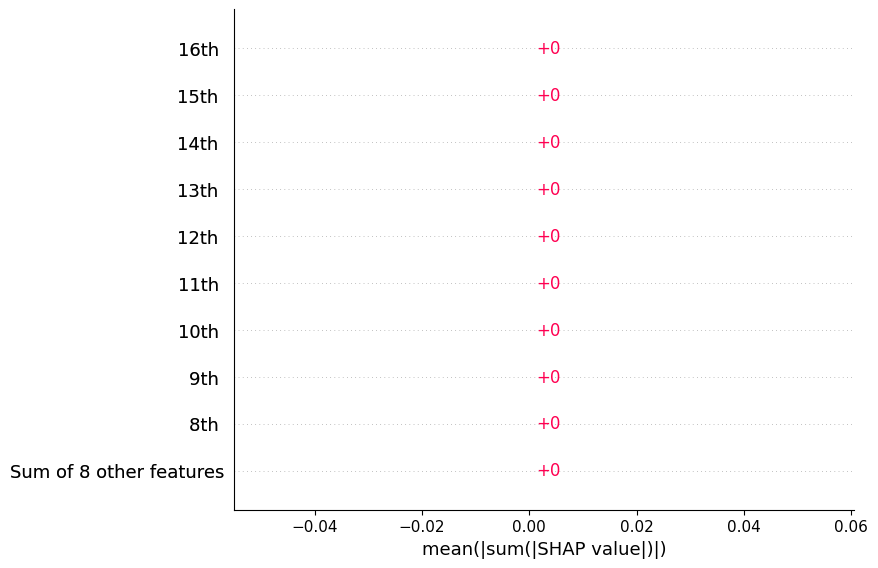

In [ ]:
# the default clustering value is of size (1, x, 4) but we need to squeeze it to (x, 4) for a single instance..
# however ultimately this should be used for multi-instance explanations s.t. each word has an average impact value
masked_shap_values.clustering = masked_shap_values.clustering.squeeze()
shap.plots.bar(masked_shap_values.abs.sum(0))


## Masking fn instead of class

In [ ]:
def custom_masker(mask, x):
    print(x.shape)
    print(mask.shape)
    print(x)
    print(mask)
    return (x * mask).reshape(1, len(x))

masked_explainer_2 = shap.Explainer(
    pred,
    output_names=[f"SDG {id2label[i]}" for i in range(17)],
    masker=custom_masker
)
masked_shap_values_2 = masked_explainer_2([sample_dataset["text"][0]])

AttributeError: 'str' object has no attribute 'shape'